# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import csv

# TODO: fill this in based on where you saved the training and testing data
training_file = "../traffic-signs-data/train.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X, Y = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
names = {}
with open('signnames.csv') as _f:
    rows = csv.reader(_f, delimiter=',')
    next(rows, None)  # skip the headers
    for row in rows:
        names[str(row[0])] = row[1]

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
sample_image_shape = train['sizes'][0]

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", sample_image_shape)
print("Number of classes =", n_classes)

print("Length features,labels,sizes  =", len(X),"," ,len(Y),",", len(train['sizes']))


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [29 30]
Number of classes = 43
Length features,labels,sizes  = 39209 , 39209 , 39209


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import scipy as scipy
import math
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import os.path
from pathlib import Path

import time
import operator
from itertools import groupby

from tensorflow.contrib.layers import flatten

import matplotlib.gridspec as gridspec
%matplotlib inline

from sklearn import model_selection
from sklearn.utils import shuffle

from utils import *

In [6]:
tf.__version__

'0.12.1'

In [7]:
X_train = list(X)

Y_train = list(Y)

assert len(X_train) == len(Y_train), 'Unbalanced X, Y lengths'

length = len(X_train)

"""
for i in range(len(X_train)):
    if i % 5000 == 0:
        print("jittering {0} of {1}".format(i, length))
    for j in range(10):
        img = transform_image(X_train[i], 20, 10, 5)
        X_train.append(img)
        Y_train.append(Y_train[j])
"""

X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train, Y_train = shuffle(X_train, Y_train)

In [8]:
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

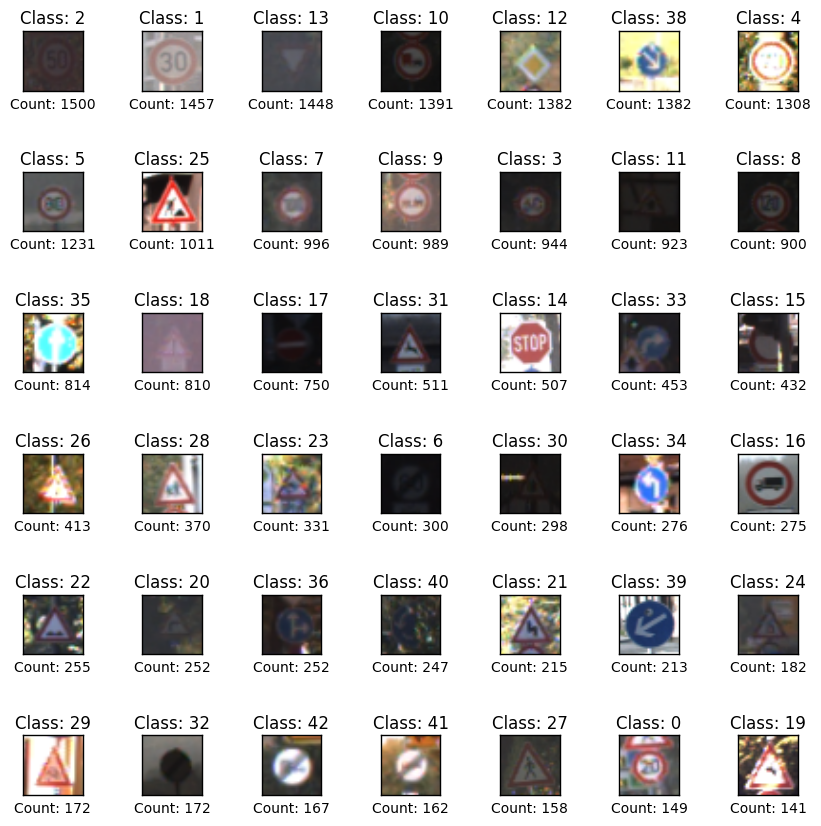

In [9]:
data = group_classes_sorted(sorted(Y_train))
images, labels, counts = get_images_and_counts(X, list(Y), data)
plot_signs(images, labels, counts)

In [10]:
print(Y_train[10000])
Y_train = dense_to_one_hot(Y_train, num_classes)
print(Y_train[10000])
Y_val = dense_to_one_hot(Y_val, num_classes)
Y_test =  dense_to_one_hot(y_test, num_classes)

12
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
# Image Tensor
images_placeholder = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')

gray = tf.image.rgb_to_grayscale(images_placeholder, name='gray')
gray /= 255.

# Label Tensor
labels_placeholder = tf.placeholder(tf.float32, shape=(None, 43), name='y')

# dropout Tensor
keep_prob = tf.placeholder(tf.float32, name='drop')

# construct model
logits = inference(gray, keep_prob)

# calculate loss
loss_value = loss(logits, labels_placeholder)

# training
train_op = training(loss_value, 0.001)

# accuracy
acc = accuracy(logits, labels_placeholder)

y_cls = tf.argmax(labels_placeholder, 1)
y_pred = tf.argmax(logits, 1)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_placeholder, 1))


saver = tf.train.Saver()
summary_op = tf.summary.merge_all()

save_step=10

In [12]:
steps = len(X_train) // BATCH_SIZE
train_num_examples = steps * BATCH_SIZE

In [13]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    acc_steps = len(X_data) // BATCH_SIZE
    for i in range(acc_steps):
        batch_val_x, batch_val_y = next_batch(X_data, y_data, BATCH_SIZE)   
        loss, accuracy = sess.run([loss_value, acc], feed_dict={
                images_placeholder: batch_val_x,
                labels_placeholder: batch_val_y,
                keep_prob: 1
                })
        total_accuracy += (accuracy * len(batch_val_x))
        total_loss += (loss * len(batch_val_x))
    return (total_accuracy / num_examples, total_loss / num_examples)

In [14]:
with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter("./gtsd-summary", sess.graph, flush_secs=1)
    my_file = Path("./checkpoints/checkpoint")
    if my_file.is_file():
    # file exists
        saver.restore(sess, './checkpoints/gtsd-01-22-17-1.chkpt')
        print("Model restored.")
    else:
        sess.run(tf.global_variables_initializer())
        print("No Model found. Initializing new variables...")
    
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, Y_train = shuffle(X_train, Y_train)
        for j in range(steps):
            # train for batch_size
            batch_x, batch_y = next_batch(X_train, Y_train, BATCH_SIZE)
            _, summaries = sess.run([train_op, summary_op], feed_dict={
                images_placeholder: batch_x,
                labels_placeholder: batch_y,
                keep_prob: 0.5})
            
        val_accuracy, val_loss = evaluate(X_val, Y_val)
        if i % 10 == 0:
            print("EPOCH {} ...".format(i+1))
            print("Validation Loss = {:.3f} and Validation Accuracy = {:.3f}".format(val_loss, val_accuracy*100))
            print()
            save_path = saver.save(sess, './checkpoints/gtsd-01-22-17-1.chkpt')
            #print("Model saved in file: %s" % save_path)
        
        if val_accuracy > .93:
            break
        
        # for TensorBoard
        summary_writer.add_summary(summaries, global_step=i)
            

Model restored.
Training...

EPOCH 1 ...
Validation Loss = 0.168 and Validation Accuracy = 94.806



In [29]:
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/gtsd-01-22-17-1.chkpt')
    print("Model restored.")
    test_accuracy = evaluate(X_test, Y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]*100))

Model restored.
Test Accuracy = 87.498


In [36]:
def plot_images(images, labels, cls_pred=None, rect_coords=None, reshape=True):
    image_size_tuple = (32,32,3)
    assert len(images) == len(labels) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        #newImgArr = scipy.misc.imresize(images[i], (30,30), interp='bilinear')
        if reshape==False:
            ax.imshow(images[i], cmap='binary') #.reshape(img_shape)
        else:
            ax.imshow(images[i].reshape(image_size_tuple), cmap='binary')
            
        # Create a Rectangle for the co-ordinates
        if rect_coords is not None:
            rect = patches.Rectangle((rect_coords[i][0],rect_coords[i][1]),(rect_coords[i][2]-rect_coords[i][0]),(rect_coords[i][3]-rect_coords[i][1]),linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(np.argmax(labels[i]))
        else:
            xlabel = "True: {0}, Pred: {1}".format(np.argmax(labels[i]), cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

def plot_example_errors():
    print("Trying to restore model...")
    saver.restore(sess, './checkpoints/gtsd-01-22-17-1.chkpt')
    print("Model restored.")
    
    feed_dict_test = {
                images_placeholder: X_val,
                labels_placeholder: Y_val,
                keep_prob: 1,
                }
    
    #correct, cls_pred = sess.run([correct_prediction, y_pred], feed_dict=)
    
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = sess.run([correct_pred, y_pred],
                                    feed_dict=feed_dict_test)
    
    #correct = tf.argmax(correct_arr, dimension=1)
    #y_pred = tf.argmax(y_pred_arr, dimension=1)
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrectImages = np.array(feed_dict_test[images_placeholder])[incorrect]
    correctImages = np.array(feed_dict_test[images_placeholder])[correct]
    
    # Get the predicted classes for those images.
    incorrect_cls_pred = cls_pred[incorrect]
    correct_cls_pred = cls_pred[correct]
    
    # Get the true classes for those images.
    incorrect_cls_true = feed_dict_test[labels_placeholder][incorrect]
    correct_cls_true = feed_dict_test[labels_placeholder][correct]
    
    #cls_true = tf.argmax(cls_true, dimension=1)
    
    # Plot the first 9 images.
    plot_images(images=correctImages[0:9], labels=correct_cls_true[0:9], cls_pred=correct_cls_pred[0:9])
    plot_images(images=incorrectImages[0:9], labels=incorrect_cls_true[0:9], cls_pred=incorrect_cls_pred[0:9])
    
def plot_example_success():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.array(feed_dict_test[x])[correct]
    images_len = len(images)
    # Get the predicted classes for those images.
    cls_pred = cls_pred[correct]

    # Get the true classes for those images.
    cls_true = feed_dict_test[y_true_cls][correct]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9], labels=cls_true[0:9], cls_pred=cls_pred[0:9])
    plot_images(images=images[images_len-9:images_len], 
                labels=cls_true[images_len-9:images_len], 
                cls_pred=cls_pred[images_len-9:images_len])

Trying to restore model...
Model restored.


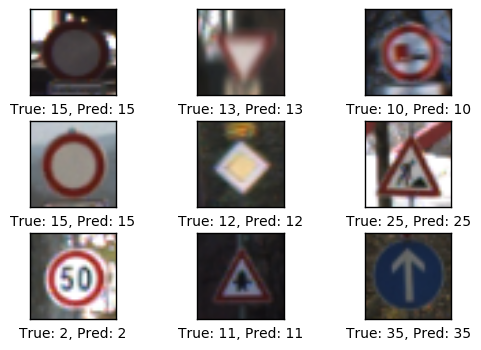

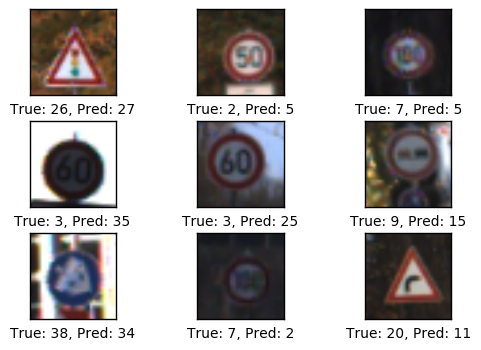

In [37]:
with tf.Session() as sess:
    plot_example_errors()

In [ ]:
def plot_accuracy():
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    #loss_plot.set_xlim([0, len(batches)])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, train_full_acc_batch, 'g', label='Training Accuracy Full')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    
    acc_plot.set_ylim([0, 1.0])
    #acc_plot.set_xlim([batches[0], batches[-1]])
    #acc_plot.set_xlim([0, len(batches)])
    acc_plot.legend(loc=2)
    plt.tight_layout()
    plt.show()

In [ ]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [ ]:
def print_weights(weightTensor):
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weightTensor)
    print("Total Weights = ", sum(w))
    #for i in range(num_classes):
    #    weights_x = w[:, i]
    #    print(i, "-->", sum(weights_x))

In [ ]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = feed_dict_test[y_true_cls]
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [ ]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.array(feed_dict_test[x])[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = feed_dict_test[y_true_cls][incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9], labels=cls_true[0:9], cls_pred=cls_pred[0:9])
    #plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

In [ ]:
def plot_example_success():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.array(feed_dict_test[x])[correct]
    images_len = len(images)
    # Get the predicted classes for those images.
    cls_pred = cls_pred[correct]

    # Get the true classes for those images.
    cls_true = feed_dict_test[y_true_cls][correct]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9], labels=cls_true[0:9], cls_pred=cls_pred[0:9])
    plot_images(images=images[images_len-9:images_len], 
                labels=cls_true[images_len-9:images_len], 
                cls_pred=cls_pred[images_len-9:images_len])

In [ ]:
def plot_weights(weightTensor):
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weightTensor)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<num_classes:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, n_classes)
            image = w[:, i].reshape(32,16,1)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
print_accuracy()
plot_accuracy()
print("Plot Batches Length = ", len(batches))

In [ ]:
plot_example_errors()

In [ ]:
plot_example_success()

In [ ]:
print_weights(weights['out'])

In [ ]:
#plot_weights(weights2)

In [ ]:
optimize(num_iterations=1)

In [ ]:
print_accuracy()

In [ ]:
#print_accuracy()
plot_example_errors()
plot_example_success()
print_weights(weights['out'])

In [ ]:
optimize(num_iterations=9)
print_accuracy()
plot_example_errors()
plot_example_success()
print_weights(weights['out'])

In [ ]:
optimize(num_iterations=1)

In [ ]:
print_accuracy()
plot_example_errors()
plot_example_success()
print_weights(weights)

In [ ]:
print_confusion_matrix()

In [ ]:
#session.close()

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
Few options used for preprocessing include - 

1) Greyscaling 
2) Using RGB and YUV

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
Here are the steps used for setup - 

1) Jitter each image in the dataset to account for potential deformations in the test set. 
2) Create the validation set, used sklearn (model_selection) to take 33% of the test set for validation.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
I created 4 networks -
1) Project File Name: Traffic_Signs_Recognition_Linear.ipynb Type: Single layer Linear model.
2) Project File Name: Traffic_Signs_Recognition_2L_RELU.ipynb Type: Two Layer deep network. Design: "Linear Weights" -> "RELU + Dropout" -> "Output Linear weights".
3) Project File Name: Traffic_Signs_Recognition_COVNET.ipynb Type: LENET based CNN. Design: "3x3x32 Convolutional layer_1" -> "2x2 Pooling" -> "fully_connected layer (512)" -> "output layer"
4) Project File Name: Traffic_Signs_Recognition_COVNET2.ipynb Type: Convolutional neural network. Design: "5x5 Convolutional layer_1" -> "5x5 Conv. layer_2" -> "5x5 Conv. layer_3" -> "fully_connected layer" -> "output layer"
            
Project 3 gave best results for me. I was able to reach 94% accuracy.    

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 

Learning rate = 0.001
Batch Size: 2500
Epochs: Max of 10000 with 93% cutoff

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** Here are the steps I followed to address the problem for Project 1, 2 and 4- 
1) Print the training and test image. This helped me understand the images we are working with. 
2) Print the images after pre-processing. This helped me understand how the final input images look like before feeding it to network. 
3) Train few iterations of the network at a time and plot all analytics - 
    a) Plot training accuracy, Loss and validation accuracy to check what is the improvement. 
    b) Plot final weight images to understand what network is learning over time 
    c) Plot confusion matrix to understand what network is doing wrong. This helped me tune some parameters in the input image (such as region of interest selection) to improve the results. 
    d) Final Accuracy score.
   
For Project 3 - I was also saving the model during training and pick from where the training was left. This helped me run the model for longer epochs.
    

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [ ]:
import os
from PIL import Image
images = os.listdir('./downloaded-images')
images = [cv2.imread('./downloaded-images/'+img) for img in images]

In [ ]:
X_test = images
y_test = np.array([1, 12, 20, 32, 15, 20, 2, 12])

In [ ]:
Y_test =  dense_to_one_hot(y_test, num_classes)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/gtsd-01-22-17-1.chkpt')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]*100))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [ ]:
with tf.Session() as sess:
    plot_example_errors()
    
## PLEASE SEE THE OUTPUT OF THIS IN THE SECTION ABOVE "In [37]". 
##Some of the images a already blurred (not proper focus) which is not properly caegorized. 

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/gtsd-01-22-17-1.chkpt')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]*100))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.